### Data loading and preparation

In [2]:
from predpairutils import *

In [3]:
dataset_file = "./data/predpair_dataset.tsv"
train_file, val_file, test_file = "./data/train_rfs.pk", "./data/val_rfs.pk", "./data/test_rfs.pk"
NN_weghts = "./data/predpair_weights.h5"

In [4]:
rf_id2seq2data, seq2rf_id = parse_data(dataset_file)
train_q, train_ans, val_q, val_ans, test_q, test_ans = prepare_data(rf_id2seq2data, train_file, val_file, test_file)

### Trained model loading

In [5]:
predpair = predpair()
predpair.load_weights(NN_weghts)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 64)     3264        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     3264        input_1[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, None, 5)      0           conv1d[0][0]                     
                                                                 input_1[0][0]                

### Calculation of the fraction of reciprocal pairs and the fraction of reciprocal among paired and unpaired nucleotides

To calculate from the data uncomment and run the cell below

In [ ]:
# paired_good_frs, unpaired_good_frs = calculate_freqs(test_q, seq2rf_id, rf_id2seq2data, predpair)

To load precalculated frequencies uncomment and run the cell below

In [ ]:
# PAIRED_FILE = './data_for_analysis/paired_good_frs.json'
# UNPAIRED_FILE = './data_for_analysis/unpaired_good_frs.json'

# with open(PAIRED_FILE, 'r') as f:
#     paired_good_frs = json.load(f)

# with open(UNPAIRED_FILE, 'r') as f:
#     unpaired_good_frs = json.load(f)

In [ ]:
plot_reciprocity(paired_good_frs, unpaired_good_frs)

### Calculation of Precision/Recall curves for the network and RNAplfold

Calculations for RNAplfold data

In [ ]:
SEQPATH = "test_seqs"
PLFOLD_PATH = "vienna_test_rez"
CONFUSION_MATRIX_PARAMETER = 1 - 0.00001

k2data = gen_data_for_pres_recall(rf_id2seq2data, SEQPATH)

In [ ]:
k2pairs_predicted = get_k2pairs_pred(PLFOLD_PATH)

In [ ]:
k2best_pairs_predicted, k2rfam_pairs = get_plfold_pairs(k2pairs_predicted, k2data)

In [ ]:
calc_confusion_matrix(k2best_pairs_predicted, k2rfam_pairs, CONFUSION_MATRIX_PARAMETER)

In [ ]:
pres, recs = calc_precision_recall_tracks(k2best_pairs_predicted, k2rfam_pairs)        

Calculations for PredPair

To calculate from the data uncomment and run the cell below

In [ ]:
# k2net_best_pairs_predicted = get_net_pairs(k2rfam_pairs, k2data, predpair)

To load precalculated predictions of PredPair uncomment and run the cell below

In [ ]:
# k2net_best_pairs_predicted = pk.load(open("./data_for_analysis/locally_computed_net_pairs.pk", 'rb'))

In [ ]:
pres_net, recs_net = calc_precision_recall_tracks(k2net_best_pairs_predicted, k2rfam_pairs)

In [ ]:
plot_prec_recall(recs, pres, recs_net, pres_net)

### Comparison of PredPair predictions with DMS-Seq data

In [6]:
GENOME_FILE = "./data_for_analysis/NC_000913.2.gb"
GENOME_LENGTH = 4639675

DMS_for = "./data_for_analysis/GSM2055260_DMS_37_WT_for.wig"
DMS_rev = "./data_for_analysis/GSM2055260_DMS_37_WT_rev.wig"

In [7]:
dms_for = get_struc_data(DMS_for, GENOME_LENGTH)
dms_rev = get_struc_data(DMS_rev, GENOME_LENGTH)

rand_qs, rand_ans = gen_rand_dms()

In [8]:
record = SeqIO.read(GENOME_FILE, "genbank")
good_genes = get_dms_genes(record, dms_for, dms_rev)

To calculate from the data uncomment and run the cell below

In [ ]:
# qs, rand_qs = get_dms_quantiles(good_genes, dms_for, dms_rev, record, predpair)

To load precalculated DMS quantiles, uncomment and run the cell below

In [10]:
with open('./data_for_analysis/qs.json', 'r') as f:
    qs = json.load(f)

with open('./data_for_analysis/rand_qs.json', 'r') as f:
    rand_qs = json.load(f)

### Comparison of RNAplfold predictions with DMS-Seq data

In [11]:
mrna_k2data = gen_mrnas_for_vienna(good_genes, record)
mrna_k2pairs_predicted = get_k2pairs_pred('./mrna_vienna_rez')

In [12]:
mrna_k2best_pairs_predicted = get_mrna_pairs_vienna(mrna_k2pairs_predicted, mrna_k2data)

In [13]:
vienna_qs, v_rand_qs = get_dms_quantiles_vienna(good_genes, record, dms_for, dms_rev, 
                                                mrna_k2data, mrna_k2best_pairs_predicted)

0
100
200
300
400


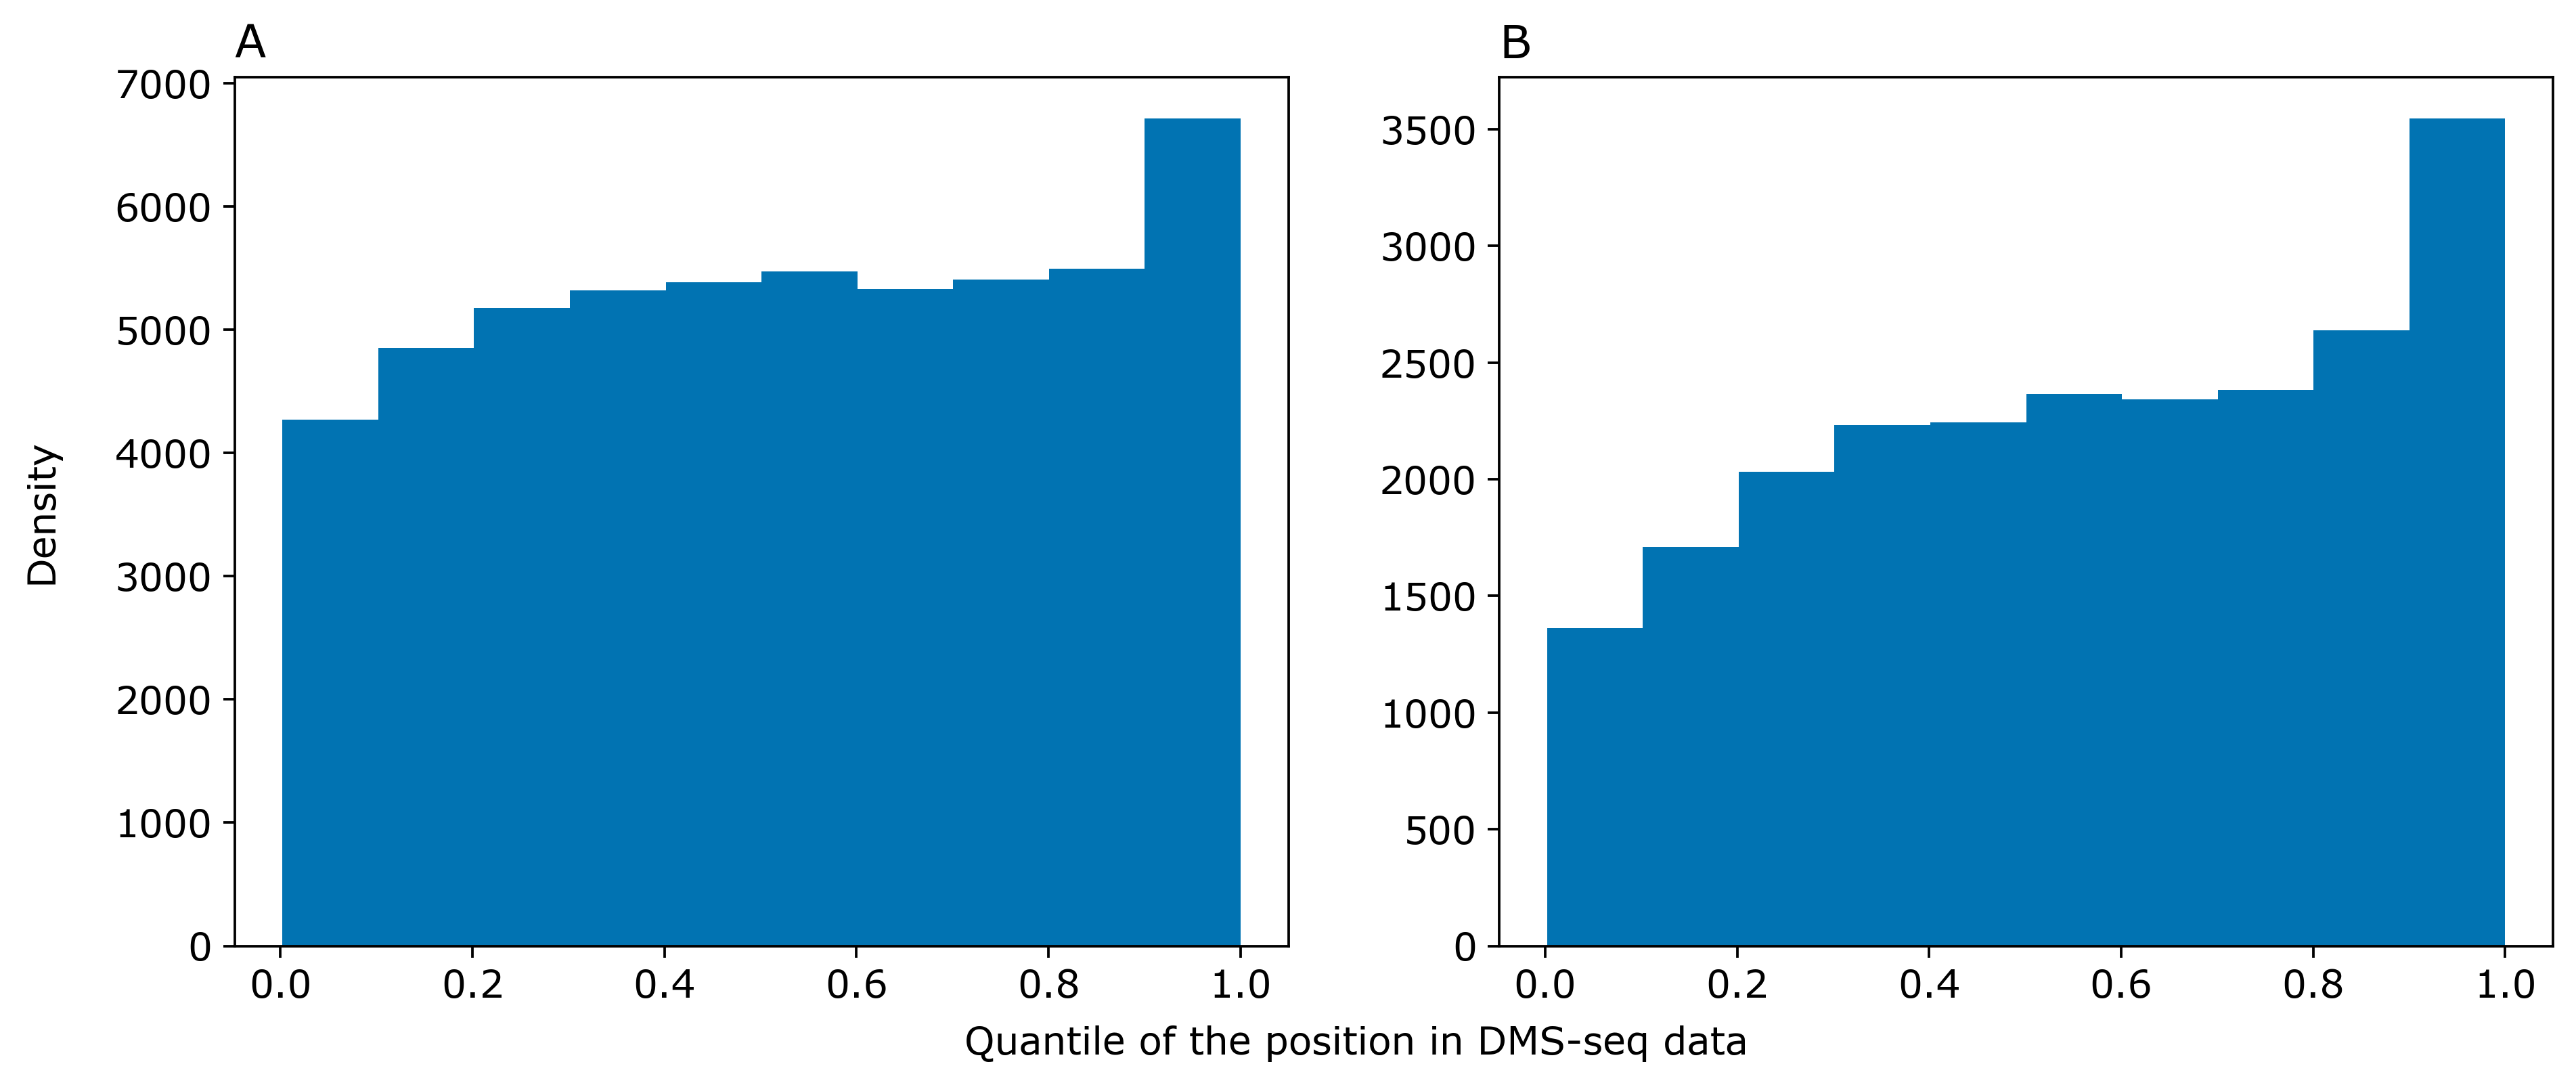

In [20]:
plot_dms(vienna_qs, qs)

In [18]:
import scipy.stats
from scipy.stats import mannwhitneyu

mannwhitneyu(qs, vienna_qs)

MannwhitneyuResult(statistic=565871298.0, pvalue=6.810141287819033e-58)

In [ ]:
###NEW AFTER REVISION END

### Analysis of DUF2693-FD motif

In [ ]:
duf2693fd_seq = "UCCUUGUAGACGGAUUGAACGGCAACACAUAGCGAGAAUGUGACAAGGA" #https://rnacentral.org/rna/URS0000D6870F/469585
duf2693fd_ss = "(((((((...((.......))....(((((.......))))))))))))" 
ans, grad = get_ans_grad(duf2693fd_seq, predpair) # The answer of the model and the gradients of the answer given the inputs.

a = symmetrize_min(ans) # Symmetrisation of the answer. Please note than sum of the row is not 1 from now.
g = symmetrize_min(get_importances(grad)) # Symmetrisation of the gradient-based importance measure

true_pairs = find_all_pairs(duf2693fd_ss)


In [ ]:
RNA_IMAGE = './data_for_analysis/URS0000D6870F_structure.png'
RNA_STRUCTURE = './data_for_analysis/duf2693fd_rnafold.png'

plot_duf2693fd(duf2693fd_seq, RNA_IMAGE, RNA_STRUCTURE, a, true_pairs)

### Analysis of a psedoknot (Rfam ID RF01105)

In [ ]:
seq_pk = "AGAGTTATCATACTCTATAAACTATGA".replace("T", "U") #https://rfam.org/family/SBWMV2_UPD-PKl#tabview=tab1, accession L07938.1
ss_pk = "<<<<________>>>>:::::::::::" #https://rnacentral.org/r2dt?jobid=r2dt-R20220208-114456-0944-64823382-p1m
ans_pk, grad_pk = get_ans_grad(seq_pk, predpair) # The answer of the model and the gradients of the answer given the inputs.

a_pk = symmetrize_min(ans_pk) # Symmetrisation of the answer. Please note than sum of the row is not 1 from now.
g_pk = symmetrize_min(get_importances(grad_pk)) # Symmetrisation of the gradient-based importance measure

true_pairs_pk = find_all_pairs(ss_pk)

In [ ]:
PK_IMAGE = './data_for_analysis/RF01105_pseudoknot.png'
plot_pk(seq_pk, PK_IMAGE, a_pk, true_pairs_pk)

### Example of analysis of feature importance for prediction (Rfam ID RF01690)

In [ ]:
seq_bac = "ATAAAAGGAACGGCGGCTAAATGCTTAGGCGTCCTGCCTAAACACCGCCGTCATCACATCCTGTAAA".replace("T", "U") #https://rfam.xfam.org/family/RF01690#tabview=tab1
ss_bac = "..........(((((((........(((((.....)))))...)))))))...(((((......)))))" #https://rnacentral.org/rna/URS000067370E/224308
ans_bac, grad_bac = get_ans_grad(seq_bac, predpair) # The answer of the model and the gradients of the answer given the inputs.

a_bac = symmetrize_min(ans_bac) # Symmetrisation of the answer. Please note than sum of the row is not 1 from now.
g_bac = symmetrize_min(get_importances(grad_bac)) # Symmetrisation of the gradient-based importance measure

true_pairs_bac = find_all_pairs(ss_bac)

In [ ]:
f = get_plot(a_bac, g_bac, seq_bac, true_pairs_bac)

### Analysis of feature importance for prediction over all data

To calculate from the data uncomment and run the cell below

In [ ]:
# at, ar, it, ir = get_pair_stat(predpair, test_q, test_ans)

To load precalculated values of importances, uncomment and run the cell below

In [ ]:
# at_text = codecs.open("./data_for_analysis/at.json", 'r', encoding='utf-8').read()
# at = json.loads(at_text)

# ar_text = codecs.open("./data_for_analysis/ar.json", 'r', encoding='utf-8').read()
# ar = json.loads(ar_text)

# it_text = codecs.open("./data_for_analysis/it.json", 'r', encoding='utf-8').read()
# it = json.loads(it_text)

# ir_text = codecs.open("./data_for_analysis/ir.json", 'r', encoding='utf-8').read()
# ir = json.loads(ir_text)

In [ ]:
print(mannwhitneyu(at, ar))

In [ ]:
it2 = [math.log(x, 10) for x in it if x != 0]
ir2 = [math.log(x, 10) for x in ir if x != 0]

print(mannwhitneyu(it2, ir2))

In [ ]:
import matplotlib.pyplot as plt

plot_importances(at, ar, it2, ir2)

### Analysis of frequencies of types of pairs and their relationship with the energy of stacking

To calculate the values, uncomment and run the cell below

To calculate frequencies of pairs and stacked pairs from sequennces, uncomment ans run the cell below

In [ ]:
# seqpath = "test_seqs"
# onlyseqs = [f for f in listdir(seqpath) if isfile(join(seqpath, f))]
# k2seq = {}

# for i in onlyseqs:
#     k = int(i.split(".")[0])
#     with open(join(seqpath, i)) as f:
#         f.readline()
#         s = f.readline().strip()
#         k2seq[k] = s
# pair2count, ppair2count = get_lets_pair_stat(k2seq, predpair)

To load precalculated values, uncomment and run two cells below

In [ ]:
# pair2count = ''
# with open(r'./data_for_analysis/pair2count.txt','r') as f:
#     for i in f.readlines():
#         pair2count = i #string
# pair2count = eval(pair2count) # this is orignal dict with instace dict


In [ ]:
# ppair2count_ = ''
# with open(r'./data_for_analysis/ppair2count.txt','r') as f:
#     for i in f.readlines():
#         ppair2count_ = i #string
# ppair2count_ = eval(ppair2count_)

# ppair2count = {}
# for p in ppair2count_:
#     ppair2count[(p[0][1] + p[1][0], p[1][1]+p[0][0])] = ppair2count_[p]/sum(ppair2count_.values())

In [ ]:
pairs, energies, counts_of_pairs, counts_of_stacked = get_energy_data(pair2count, ppair2count)

In [ ]:
plot_energy_data(pairs, energies, counts_of_pairs, counts_of_stacked)

### t-SNE analysis of embeddings of RNA sequences from different Rfam families

In [ ]:
RFAM_SEED = "./data/Rfam.seed"

alns_good, data_good = clean_raw_rfam(RFAM_SEED)
alns_filtered, data_filtered = filter_by_fr(0.2, data_good, alns_good)
data_filtered, alns_filtered = filter_by_clan(alns_filtered, data_filtered)
ds = gen_pre_dataset(data_filtered, alns_filtered)

To create embeddings from RNA sequences from **ds** using PredPair, uncomment ans run the cell below

In [ ]:
# class2seqs = make_class2seqs(ds)
# cl2embs = make_cl2embs(predpair, class2seqs, layer_name='bidirectional_1') #layer name is taken from the cell output of predpair() function 

To load precalculated embeddings uncomment and run the cell below

In [ ]:
# outfile = './data_for_analysis/cl2embs.npz'
# cl2embs = np.load(outfile)

# rand_outfile = './data_for_analysis/rand_seqs2embs.npz'
# rand_seqs2embs = np.load(rand_outfile)

In [ ]:
tsne = TSNE()

x, y = sample_data(cl2embs)
x_embedded = tsne.fit_transform(x)

x_r, y_r = sample_data(rand_seqs2embs)
xr_embedded = tsne.fit_transform(x_r)


To create embeddings from RNA sequences from **random sequences that can maintain RNA structure** using PredPair, uncomment ans run the cell below

In [ ]:
# RAND_SEQS = './data_for_analysis/random_seqs_by_classes_len_140_di.txt' 
# rand_seqs2embs = make_rand_seqs2embs(RAND_SEQS, predpair, layer_name='bidirectional_1')

In [ ]:
plot_tsne(y, y_r, x_embedded, xr_embedded)